In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete2.csv')
# 预测第二天用药，第一天当做历史信息
x = df.iloc[:,5:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+300]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)


# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)




In [6]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=256,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l2(0.001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




create model. feature_dim =2372, label_dim =300
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 256)               607488    
                                                                 
 dense_203 (Dense)           (None, 256)               65792     
                                                                 
 dense_204 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 17ms/step - loss: 0.4526 - JI: 0.0321 - val_loss: 0.1138 - val_JI: 0.0197
Epoch 2/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1137 - JI: 0.0302 - val_loss: 0.1068 - val_JI: 0.0357

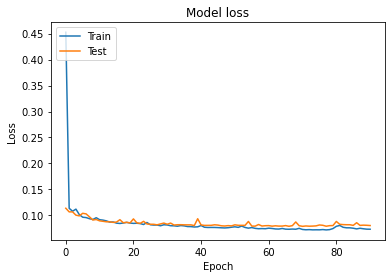

验证集上的最优结果是0.21226294338703156,对应训练轮次是77
create model. feature_dim =2372, label_dim =300
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_205 (Dense)           (None, 256)               607488    
                                                                 
 dense_206 (Dense)           (None, 256)               65792     
                                                                 
 dense_207 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 18ms/step - loss: 0.3481 - JI: 0.0289 - val_loss: 0.1199 - val_JI: 0.0335
Epoch 2/500
110/110 [==============================] - 2s 15ms/step - loss: 0.1206 - JI: 0.

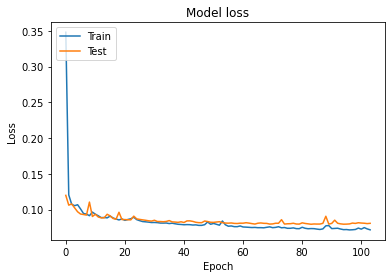

验证集上的最优结果是0.2119806408882141,对应训练轮次是101
create model. feature_dim =2372, label_dim =300
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 256)               607488    
                                                                 
 dense_209 (Dense)           (None, 256)               65792     
                                                                 
 dense_210 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.5324 - JI: 0.0276 - val_loss: 0.1117 - val_JI: 0.0249
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1171 - JI: 0.03

110/110 [==============================] - 1s 8ms/step - loss: 0.0727 - JI: 0.2310 - val_loss: 0.0808 - val_JI: 0.1745
Epoch 119/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0747 - JI: 0.2318 - val_loss: 0.0831 - val_JI: 0.1767
Epoch 120/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0765 - JI: 0.2157 - val_loss: 0.0863 - val_JI: 0.1629


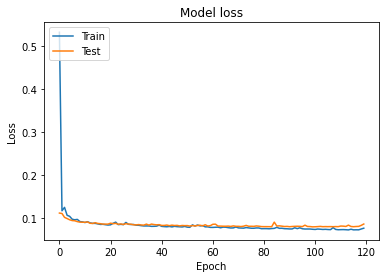

验证集上的最优结果是0.19288739562034607,对应训练轮次是115
create model. feature_dim =2372, label_dim =300
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_211 (Dense)           (None, 256)               607488    
                                                                 
 dense_212 (Dense)           (None, 256)               65792     
                                                                 
 dense_213 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.4246 - JI: 0.0342 - val_loss: 0.2095 - val_JI: 0.0330
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1084 - JI: 0.0

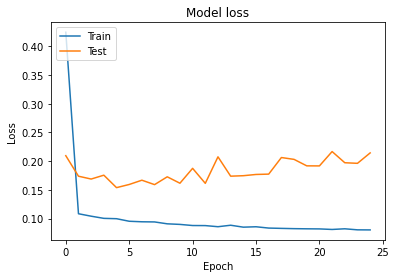

验证集上的最优结果是0.18070760369300842,对应训练轮次是24
create model. feature_dim =2372, label_dim =300
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_214 (Dense)           (None, 256)               607488    
                                                                 
 dense_215 (Dense)           (None, 256)               65792     
                                                                 
 dense_216 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.4821 - JI: 0.0313 - val_loss: 0.1109 - val_JI: 0.0282
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1149 - JI: 0.03

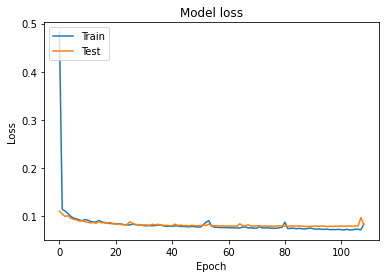

验证集上的最优结果是0.19785849750041962,对应训练轮次是102
create model. feature_dim =2372, label_dim =300
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 256)               607488    
                                                                 
 dense_218 (Dense)           (None, 256)               65792     
                                                                 
 dense_219 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 15ms/step - loss: 0.3980 - JI: 0.0301 - val_loss: 0.1224 - val_JI: 0.0290
Epoch 2/500
110/110 [==============================] - 1s 12ms/step - loss: 0.1247 - JI: 0

Epoch 56/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0764 - JI: 0.2025 - val_loss: 0.0810 - val_JI: 0.1675
Epoch 57/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0760 - JI: 0.2048 - val_loss: 0.0831 - val_JI: 0.1672
Epoch 58/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0774 - JI: 0.1987 - val_loss: 0.0814 - val_JI: 0.1765
Epoch 59/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0758 - JI: 0.2063 - val_loss: 0.0817 - val_JI: 0.1833
Epoch 60/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0753 - JI: 0.2104 - val_loss: 0.0814 - val_JI: 0.1690
Epoch 61/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0749 - JI: 0.2112 - val_loss: 0.0819 - val_JI: 0.1806
Epoch 62/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0747 - JI: 0.2133 - val_loss: 0.0827 - val_JI: 0.1585
Epoch 63/500
110/110 [==============================] - 1s 13ms/step 

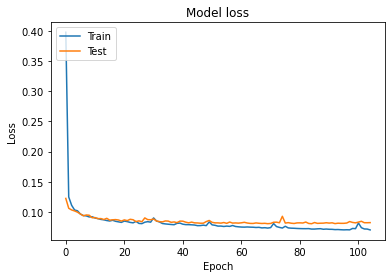

验证集上的最优结果是0.20379337668418884,对应训练轮次是92
create model. feature_dim =2372, label_dim =300
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 256)               607488    
                                                                 
 dense_221 (Dense)           (None, 256)               65792     
                                                                 
 dense_222 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4362 - JI: 0.0273 - val_loss: 0.1172 - val_JI: 0.0230
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1146 - JI: 0.02

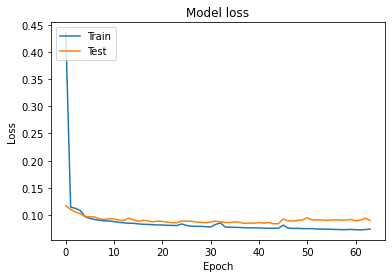

验证集上的最优结果是0.20367220044136047,对应训练轮次是54
create model. feature_dim =2372, label_dim =300
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_223 (Dense)           (None, 256)               607488    
                                                                 
 dense_224 (Dense)           (None, 256)               65792     
                                                                 
 dense_225 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.3545 - JI: 0.0298 - val_loss: 0.1108 - val_JI: 0.0276
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1149 - JI: 0.03

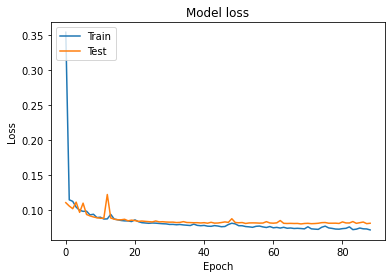

验证集上的最优结果是0.19966243207454681,对应训练轮次是85
create model. feature_dim =2372, label_dim =300
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_226 (Dense)           (None, 256)               607488    
                                                                 
 dense_227 (Dense)           (None, 256)               65792     
                                                                 
 dense_228 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4453 - JI: 0.0310 - val_loss: 0.1173 - val_JI: 0.0435
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1248 - JI: 0.03

KeyboardInterrupt: 

In [10]:
# 十折交叉验证
results = []
from sklearn.model_selection import KFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):
    X_train = x[train].astype(np.float64)
    X_test = x[test].astype(np.float64)
    y_train = y[train].astype(np.int32)
    y_test = y[test].astype(np.int32)
    results.append(train_DNN(X_train,y_train,X_test,y_test))

In [15]:
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

train_DNN(X_train,y_train,X_test,y_test)

In [4]:
# 参数调节
import tensorflow as tf
lr_list = [1,0.1,0.01,0.001,0.0001]

optimizer_list = []
for i in lr_list:
    optimizer_list.append(tf.keras.optimizers.SGD(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adagrad(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adadelta(learning_rate=i))
    optimizer_list.append(tf.keras.optimizers.Adam(learning_rate=i))

hidden_layer_num_list=[1,2,3,4,5,6,7,8]
hidden_layer_units_list=[512,256,128,64,32,16]
batch_size_list=[512,256,128,64]
hidden_layer_dropout_list = [True,False]
input_layer_dropout_list = [True,False]
dropout_rate_list = [0.1,0.2,0.3,0.4,0.5]
use_kernel_regularizer_list = [True,False]
re_cof_list = [1,0.1,0.01,0.001,0.0001,0.00001,0.000001]
kernel_regularizer_list = []
for i in re_cof_list:
    kernel_regularizer_list.append(tf.keras.regularizers.l1(i))
    kernel_regularizer_list.append(tf.keras.regularizers.l2(i))





create model. feature_dim =2372, label_dim =300
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               1214976   
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 300)               153900    
                                                                 
Total params: 1,631,532
Trainable params: 1,631,532
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 14ms/step - loss: 0.4132 - JI: 0.0326 - val_loss: 0.1107 - val_JI: 0.0342
Epoch 2/500
110/110 [==============================] - 1s 13ms/step - loss: 0.1331 - JI: 0.0405 - val_loss: 0.1045 - val_JI: 0.0

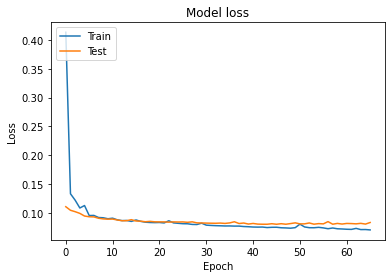

验证集上的最优结果是0.20248791575431824,对应训练轮次是53
create model. feature_dim =2372, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               607488    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.3878 - JI: 0.0318 - val_loss: 0.1268 - val_JI: 0.0206
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1164 - JI: 0.029

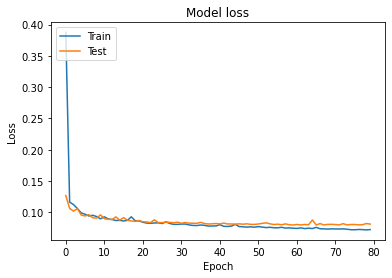

验证集上的最优结果是0.2031155526638031,对应训练轮次是73
create model. feature_dim =2372, label_dim =300
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               303744    
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 300)               38700     
                                                                 
Total params: 358,956
Trainable params: 358,956
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 6ms/step - loss: 0.4409 - JI: 0.0224 - val_loss: 0.1142 - val_JI: 0.0141
Epoch 2/500
110/110 [==============================] - 1s 5ms/step - loss: 0.1149 - JI: 0.0209

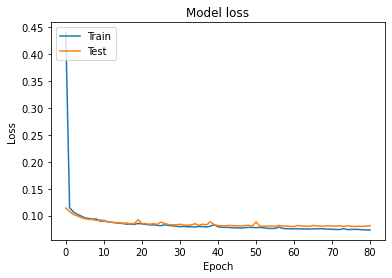

验证集上的最优结果是0.19973205029964447,对应训练轮次是70
create model. feature_dim =2372, label_dim =300
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                151872    
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 300)               19500     
                                                                 
Total params: 175,532
Trainable params: 175,532
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 5ms/step - loss: 0.5665 - JI: 0.0211 - val_loss: 0.1115 - val_JI: 0.0123
Epoch 2/500
110/110 [==============================] - 0s 4ms/step - loss: 0.1149 - JI: 0.013

110/110 [==============================] - 0s 4ms/step - loss: 0.0783 - JI: 0.1823 - val_loss: 0.0819 - val_JI: 0.1598
Epoch 119/500
110/110 [==============================] - 0s 4ms/step - loss: 0.0780 - JI: 0.1844 - val_loss: 0.0821 - val_JI: 0.1595
Epoch 120/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0783 - JI: 0.1838 - val_loss: 0.0823 - val_JI: 0.1438
Epoch 121/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0781 - JI: 0.1833 - val_loss: 0.0819 - val_JI: 0.1552
Epoch 122/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0782 - JI: 0.1844 - val_loss: 0.0829 - val_JI: 0.1629
Epoch 123/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0781 - JI: 0.1845 - val_loss: 0.0839 - val_JI: 0.1522
Epoch 124/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0783 - JI: 0.1831 - val_loss: 0.0822 - val_JI: 0.1531
Epoch 125/500
110/110 [==============================] - 0s 4ms/step - loss: 0.0779

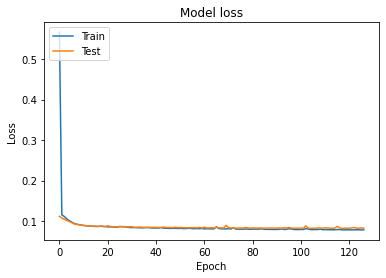

验证集上的最优结果是0.1777307689189911,对应训练轮次是106
create model. feature_dim =2372, label_dim =300
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                75936     
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 300)               9900      
                                                                 
Total params: 86,892
Trainable params: 86,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 5ms/step - loss: 0.5084 - JI: 0.0229 - val_loss: 0.1150 - val_JI: 0.0159
Epoch 2/500
110/110 [==============================] - 0s 4ms/step - loss: 0.1144 - JI: 0.0120 

110/110 [==============================] - 1s 8ms/step - loss: 0.0777 - JI: 0.1878 - val_loss: 0.0814 - val_JI: 0.1544
Epoch 119/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0785 - JI: 0.1839 - val_loss: 0.0838 - val_JI: 0.1580
Epoch 120/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0784 - JI: 0.1853 - val_loss: 0.0807 - val_JI: 0.1650
Epoch 121/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0776 - JI: 0.1880 - val_loss: 0.0812 - val_JI: 0.1651
Epoch 122/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0776 - JI: 0.1882 - val_loss: 0.0815 - val_JI: 0.1749
Epoch 123/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0774 - JI: 0.1893 - val_loss: 0.0815 - val_JI: 0.1684
Epoch 124/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0776 - JI: 0.1896 - val_loss: 0.0813 - val_JI: 0.1712
Epoch 125/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0773

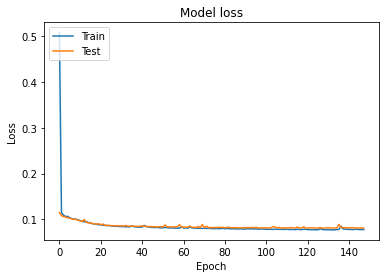

验证集上的最优结果是0.1830090582370758,对应训练轮次是134
create model. feature_dim =2372, label_dim =300
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                37968     
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 dense_20 (Dense)            (None, 300)               5100      
                                                                 
Total params: 43,340
Trainable params: 43,340
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 11ms/step - loss: 0.7201 - JI: 0.0160 - val_loss: 0.1117 - val_JI: 0.0015
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1149 - JI: 6.9967

110/110 [==============================] - 0s 3ms/step - loss: 0.0937 - JI: 0.0683 - val_loss: 0.0934 - val_JI: 0.0624
Epoch 57/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0933 - JI: 0.0687 - val_loss: 0.0931 - val_JI: 0.0640
Epoch 58/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0931 - JI: 0.0691 - val_loss: 0.0930 - val_JI: 0.0631
Epoch 59/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0929 - JI: 0.0693 - val_loss: 0.0933 - val_JI: 0.0702
Epoch 60/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0932 - JI: 0.0681 - val_loss: 0.0929 - val_JI: 0.0648
Epoch 61/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0928 - JI: 0.0701 - val_loss: 0.0930 - val_JI: 0.0561
Epoch 62/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0927 - JI: 0.0690 - val_loss: 0.0930 - val_JI: 0.0683
Epoch 63/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0927 - JI: 

110/110 [==============================] - 0s 3ms/step - loss: 0.0918 - JI: 0.0748 - val_loss: 0.0998 - val_JI: 0.0648
Epoch 119/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0919 - JI: 0.0715 - val_loss: 0.0922 - val_JI: 0.0768
Epoch 120/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0913 - JI: 0.0765 - val_loss: 0.0920 - val_JI: 0.0708
Epoch 121/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0913 - JI: 0.0748 - val_loss: 0.0920 - val_JI: 0.0726
Epoch 122/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0913 - JI: 0.0756 - val_loss: 0.0920 - val_JI: 0.0668
Epoch 123/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0913 - JI: 0.0764 - val_loss: 0.0973 - val_JI: 0.0667
Epoch 124/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0919 - JI: 0.0727 - val_loss: 0.0920 - val_JI: 0.0722
Epoch 125/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0912

Epoch 180/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0914 - JI: 0.0805 - val_loss: 0.0915 - val_JI: 0.0714
Epoch 181/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0905 - JI: 0.0833 - val_loss: 0.0915 - val_JI: 0.0788
Epoch 182/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0907 - JI: 0.0827 - val_loss: 0.0915 - val_JI: 0.0737
Epoch 183/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0905 - JI: 0.0838 - val_loss: 0.0915 - val_JI: 0.0793
Epoch 184/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0904 - JI: 0.0844 - val_loss: 0.0915 - val_JI: 0.0725
Epoch 185/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0905 - JI: 0.0845 - val_loss: 0.0919 - val_JI: 0.0774
Epoch 186/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0904 - JI: 0.0844 - val_loss: 0.0915 - val_JI: 0.0759
Epoch 187/500
110/110 [==============================] - 0s 3ms/step 

Epoch 303/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0881 - JI: 0.1163 - val_loss: 0.0895 - val_JI: 0.1065
Epoch 304/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0881 - JI: 0.1173 - val_loss: 0.0897 - val_JI: 0.1001
Epoch 305/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0882 - JI: 0.1159 - val_loss: 0.0900 - val_JI: 0.1167
Epoch 306/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0888 - JI: 0.1154 - val_loss: 0.0898 - val_JI: 0.1046
Epoch 307/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0880 - JI: 0.1172 - val_loss: 0.0895 - val_JI: 0.1007
Epoch 308/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0881 - JI: 0.1173 - val_loss: 0.0905 - val_JI: 0.0959
Epoch 309/500
110/110 [==============================] - 0s 3ms/step - loss: 0.0892 - JI: 0.1137 - val_loss: 0.0891 - val_JI: 0.1045
Epoch 310/500
110/110 [==============================] - 0s 3ms/step 

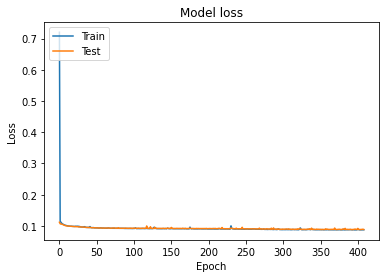

验证集上的最优结果是0.12159712612628937,对应训练轮次是381


[0.20248791575431824,
 0.2031155526638031,
 0.19973205029964447,
 0.1777307689189911,
 0.1830090582370758,
 0.12159712612628937]

In [5]:
# 调节隐层单元数
result_list = []
for i in hidden_layer_units_list:
    result_list.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_units=i))
result_list

create model. feature_dim =2372, label_dim =300
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               607488    
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4373 - JI: 0.0329 - val_loss: 0.1100 - val_JI: 0.0252
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1174 - JI: 0.0404 - val_loss: 0.1043 - val_JI: 0.0520
Ep

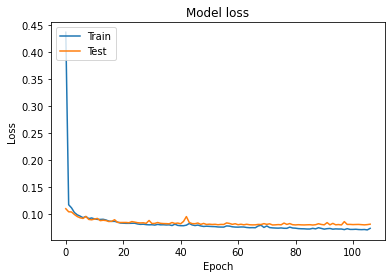

验证集上的最优结果是0.206781804561615,对应训练轮次是90
create model. feature_dim =2372, label_dim =300
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               607488    
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 256)               65792     
                                                                 
 dense_27 (Dense)            (None, 300)               77100     
                                                                 
Total params: 816,172
Trainable params: 816,172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 9ms/step - loss: 0.2739 - JI: 0.0200

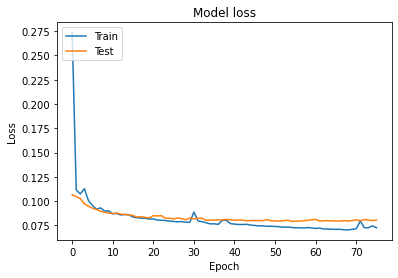

验证集上的最优结果是0.2002888023853302,对应训练轮次是64
create model. feature_dim =2372, label_dim =300
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               607488    
                                                                 
 dense_29 (Dense)            (None, 256)               65792     
                                                                 
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 300)               77100     
                                                                 
Total params: 881,964
Trainable params: 881,964
Non-trainable params: 0
___________________________

Epoch 54/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0739 - JI: 0.2170 - val_loss: 0.0807 - val_JI: 0.1585
Epoch 55/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0740 - JI: 0.2168 - val_loss: 0.0794 - val_JI: 0.1978
Epoch 56/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0735 - JI: 0.2204 - val_loss: 0.0797 - val_JI: 0.1894
Epoch 57/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0735 - JI: 0.2210 - val_loss: 0.0791 - val_JI: 0.1971
Epoch 58/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0731 - JI: 0.2237 - val_loss: 0.0797 - val_JI: 0.1893
Epoch 59/500
110/110 [==============================] - ETA: 0s - loss: 0.0730 - JI: 0.22 - 1s 9ms/step - loss: 0.0730 - JI: 0.2246 - val_loss: 0.0805 - val_JI: 0.1820
Epoch 60/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0727 - JI: 0.2277 - val_loss: 0.0802 - val_JI: 0.1902
Epoch 61/500
110/110 [================

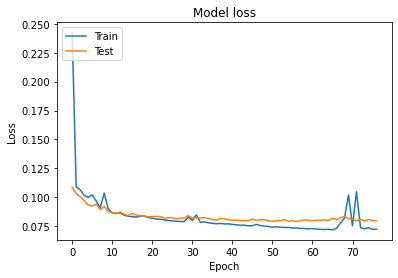

验证集上的最优结果是0.2020982801914215,对应训练轮次是74
create model. feature_dim =2372, label_dim =300
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               607488    
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 256)               65792     
                                                                 
 dense_37 (Dense)            (None, 256)               65792     
                                                                 
 dense_38 (Dense)            (None, 300)               77100     
                                

110/110 [==============================] - 1s 8ms/step - loss: 0.0777 - JI: 0.1953 - val_loss: 0.0796 - val_JI: 0.1827
Epoch 54/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0764 - JI: 0.2001 - val_loss: 0.0805 - val_JI: 0.1832
Epoch 55/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0760 - JI: 0.2021 - val_loss: 0.0794 - val_JI: 0.1705
Epoch 56/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0773 - JI: 0.2042 - val_loss: 0.0802 - val_JI: 0.1801
Epoch 57/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0767 - JI: 0.2043 - val_loss: 0.0799 - val_JI: 0.1765
Epoch 58/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0753 - JI: 0.2065 - val_loss: 0.0799 - val_JI: 0.1954
Epoch 59/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0749 - JI: 0.2100 - val_loss: 0.0803 - val_JI: 0.1802
Epoch 60/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0745 - JI: 

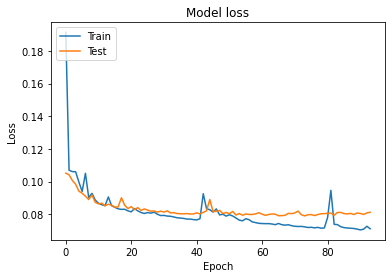

验证集上的最优结果是0.20749050378799438,对应训练轮次是76
create model. feature_dim =2372, label_dim =300
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               607488    
                                                                 
 dense_40 (Dense)            (None, 256)               65792     
                                                                 
 dense_41 (Dense)            (None, 256)               65792     
                                                                 
 dense_42 (Dense)            (None, 256)               65792     
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 dense_44 (Dense)            (None, 256)               65792     
                               

110/110 [==============================] - 1s 9ms/step - loss: 0.0760 - JI: 0.2001 - val_loss: 0.0803 - val_JI: 0.1887
Epoch 53/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0761 - JI: 0.2005 - val_loss: 0.0801 - val_JI: 0.1712
Epoch 54/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0760 - JI: 0.1993 - val_loss: 0.0803 - val_JI: 0.1723
Epoch 55/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0758 - JI: 0.2015 - val_loss: 0.0799 - val_JI: 0.1727
Epoch 56/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0755 - JI: 0.2037 - val_loss: 0.0797 - val_JI: 0.1601
Epoch 57/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0751 - JI: 0.2057 - val_loss: 0.0797 - val_JI: 0.1822
Epoch 58/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0751 - JI: 0.2073 - val_loss: 0.0796 - val_JI: 0.1784
Epoch 59/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0751 - JI: 

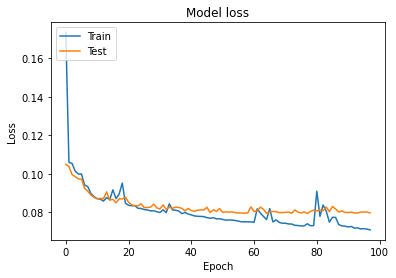

验证集上的最优结果是0.19550606608390808,对应训练轮次是85
create model. feature_dim =2372, label_dim =300
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 256)               607488    
                                                                 
 dense_47 (Dense)            (None, 256)               65792     
                                                                 
 dense_48 (Dense)            (None, 256)               65792     
                                                                 
 dense_49 (Dense)            (None, 256)               65792     
                                                                 
 dense_50 (Dense)            (None, 256)               65792     
                                                                 
 dense_51 (Dense)            (None, 256)               65792     
                               

110/110 [==============================] - 1s 10ms/step - loss: 0.0768 - JI: 0.1926 - val_loss: 0.0804 - val_JI: 0.1715
Epoch 52/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0762 - JI: 0.1963 - val_loss: 0.0804 - val_JI: 0.1792
Epoch 53/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0763 - JI: 0.1973 - val_loss: 0.0821 - val_JI: 0.1605
Epoch 54/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0761 - JI: 0.1981 - val_loss: 0.0798 - val_JI: 0.1743
Epoch 55/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0757 - JI: 0.2021 - val_loss: 0.0797 - val_JI: 0.1784
Epoch 56/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0756 - JI: 0.2018 - val_loss: 0.0812 - val_JI: 0.1772
Epoch 57/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0758 - JI: 0.2009 - val_loss: 0.0801 - val_JI: 0.1741
Epoch 58/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0758 

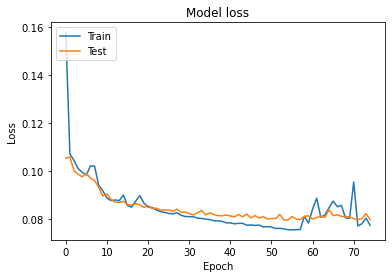

验证集上的最优结果是0.18094497919082642,对应训练轮次是75
create model. feature_dim =2372, label_dim =300
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 256)               607488    
                                                                 
 dense_55 (Dense)            (None, 256)               65792     
                                                                 
 dense_56 (Dense)            (None, 256)               65792     
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dense_58 (Dense)            (None, 256)               65792     
                                                                 
 dense_59 (Dense)            (None, 256)               65792     
                               

Epoch 50/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0777 - JI: 0.1859 - val_loss: 0.0812 - val_JI: 0.1720
Epoch 51/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0775 - JI: 0.1883 - val_loss: 0.0811 - val_JI: 0.1766
Epoch 52/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0776 - JI: 0.1878 - val_loss: 0.0813 - val_JI: 0.1639
Epoch 53/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0773 - JI: 0.1895 - val_loss: 0.0813 - val_JI: 0.1558
Epoch 54/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0777 - JI: 0.1882 - val_loss: 0.0828 - val_JI: 0.1720
Epoch 55/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0770 - JI: 0.1918 - val_loss: 0.0809 - val_JI: 0.1820
Epoch 56/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0770 - JI: 0.1931 - val_loss: 0.0815 - val_JI: 0.1720
Epoch 57/500
110/110 [==============================] - 1s 10ms/step -

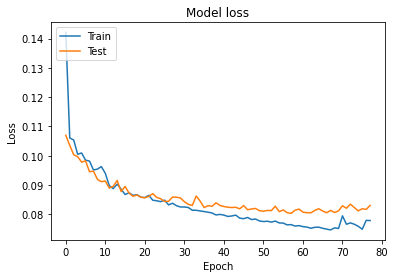

验证集上的最优结果是0.1854066103696823,对应训练轮次是76
create model. feature_dim =2372, label_dim =300
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 256)               607488    
                                                                 
 dense_64 (Dense)            (None, 256)               65792     
                                                                 
 dense_65 (Dense)            (None, 256)               65792     
                                                                 
 dense_66 (Dense)            (None, 256)               65792     
                                                                 
 dense_67 (Dense)            (None, 256)               65792     
                                                                 
 dense_68 (Dense)            (None, 256)               65792     
                                

Epoch 49/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0825 - JI: 0.1684 - val_loss: 0.0819 - val_JI: 0.1832
Epoch 50/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0832 - JI: 0.1764 - val_loss: 0.0815 - val_JI: 0.1697
Epoch 51/500
110/110 [==============================] - 2s 17ms/step - loss: 0.0857 - JI: 0.1658 - val_loss: 0.0821 - val_JI: 0.1736
Epoch 52/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0789 - JI: 0.1774 - val_loss: 0.0809 - val_JI: 0.1736
Epoch 53/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0785 - JI: 0.1809 - val_loss: 0.0812 - val_JI: 0.1691
Epoch 54/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0788 - JI: 0.1804 - val_loss: 0.0822 - val_JI: 0.1469
Epoch 55/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0829 - JI: 0.1707 - val_loss: 0.0817 - val_JI: 0.1647
Epoch 56/500
110/110 [==============================] - 1s 10ms/step 

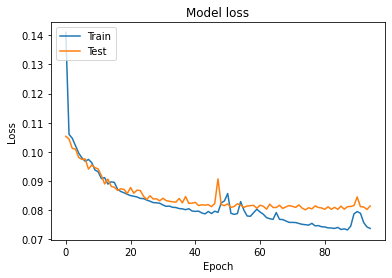

验证集上的最优结果是0.19357217848300934,对应训练轮次是78


[0.20248791575431824,
 0.2031155526638031,
 0.19973205029964447,
 0.1777307689189911,
 0.1830090582370758,
 0.12159712612628937,
 0.206781804561615,
 0.2002888023853302,
 0.2020982801914215,
 0.20749050378799438,
 0.19550606608390808,
 0.18094497919082642,
 0.1854066103696823,
 0.19357217848300934]

In [7]:
# 调节隐层层数
for i in hidden_layer_num_list:
    result_list.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num=i))
result_list

create model. feature_dim =2372, label_dim =300
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 256)               607488    
                                                                 
 dense_77 (Dense)            (None, 256)               65792     
                                                                 
 dense_78 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 1209.5129 - JI: 0.0359 - val_loss: 31.9905 - val_JI: 0.0664
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 11.0386 - JI: 0.0062 - val_loss: 8.1585 - val_JI: 3.7

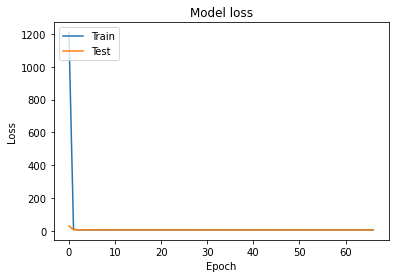

验证集上的最优结果是0.06635604798793793,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 256)               607488    
                                                                 
 dense_80 (Dense)            (None, 256)               65792     
                                                                 
 dense_81 (Dense)            (None, 256)               65792     
                                                                 
 dense_82 (Dense)            (None, 256)               65792     
                                                                 
 dense_83 (Dense)            (None, 256)               65792     
                                                                 
 dense_84 (Dense)            (None, 300)               77100     
                                

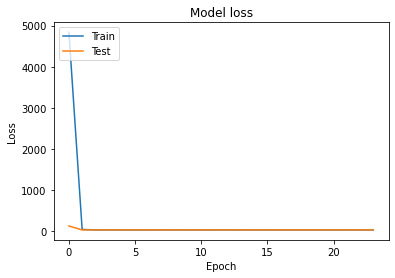

验证集上的最优结果是0.052160222083330154,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 256)               607488    
                                                                 
 dense_86 (Dense)            (None, 256)               65792     
                                                                 
 dense_87 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 74.2894 - JI: 0.0258 - val_loss: 4.8848 - val_JI: 0.0068
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 1.0507 - JI: 0.0

Epoch 56/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1092 - JI: 0.0835 - val_loss: 0.1585 - val_JI: 0.0871
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1044 - JI: 0.0844 - val_loss: 0.0949 - val_JI: 0.0829
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0950 - JI: 0.0841 - val_loss: 0.0968 - val_JI: 0.0839
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0947 - JI: 0.0838 - val_loss: 0.0958 - val_JI: 0.0711
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0947 - JI: 0.0843 - val_loss: 0.0951 - val_JI: 0.0832
Epoch 61/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0948 - JI: 0.0866 - val_loss: 0.0941 - val_JI: 0.0708
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0951 - JI: 0.0854 - val_loss: 0.0949 - val_JI: 0.0863
Epoch 63/500
110/110 [==============================] - 1s 7ms/step - loss: 

Epoch 118/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0895 - JI: 0.1118 - val_loss: 0.0903 - val_JI: 0.0982
Epoch 119/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0894 - JI: 0.1119 - val_loss: 0.0895 - val_JI: 0.1156
Epoch 120/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0892 - JI: 0.1127 - val_loss: 0.0896 - val_JI: 0.1156
Epoch 121/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0903 - JI: 0.1134 - val_loss: 0.0901 - val_JI: 0.0980
Epoch 122/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0894 - JI: 0.1133 - val_loss: 0.0897 - val_JI: 0.0937
Epoch 123/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0892 - JI: 0.1137 - val_loss: 0.0898 - val_JI: 0.1206
Epoch 124/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0892 - JI: 0.1140 - val_loss: 0.0895 - val_JI: 0.0953
Epoch 125/500
110/110 [==============================] - 1s 8ms/step 

Epoch 240/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0853 - JI: 0.1376 - val_loss: 0.0860 - val_JI: 0.1306
Epoch 241/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0852 - JI: 0.1383 - val_loss: 0.0859 - val_JI: 0.1360
Epoch 242/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0853 - JI: 0.1380 - val_loss: 0.0860 - val_JI: 0.1341
Epoch 243/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0852 - JI: 0.1392 - val_loss: 0.0860 - val_JI: 0.1264
Epoch 244/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0852 - JI: 0.1383 - val_loss: 0.0863 - val_JI: 0.1374
Epoch 245/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0852 - JI: 0.1386 - val_loss: 0.0867 - val_JI: 0.1027
Epoch 246/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0851 - JI: 0.1389 - val_loss: 0.0861 - val_JI: 0.1215
Epoch 247/500
110/110 [==============================] - 1s 12

110/110 [==============================] - 1s 7ms/step - loss: 0.0845 - JI: 0.1449 - val_loss: 0.0856 - val_JI: 0.1352
Epoch 363/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0845 - JI: 0.1446 - val_loss: 0.0858 - val_JI: 0.1437
Epoch 364/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0844 - JI: 0.1455 - val_loss: 0.0860 - val_JI: 0.1476
Epoch 365/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0845 - JI: 0.1450 - val_loss: 0.0855 - val_JI: 0.1258
Epoch 366/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0843 - JI: 0.1461 - val_loss: 0.0860 - val_JI: 0.1475
Epoch 367/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0842 - JI: 0.1458 - val_loss: 0.0856 - val_JI: 0.1442
Epoch 368/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0843 - JI: 0.1459 - val_loss: 0.0857 - val_JI: 0.1386
Epoch 369/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0844

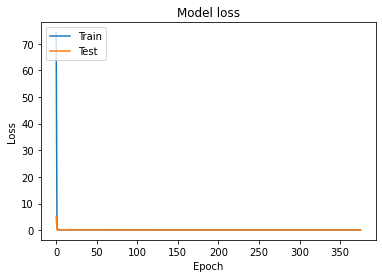

验证集上的最优结果是0.1610405147075653,对应训练轮次是326
create model. feature_dim =2372, label_dim =300
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 256)               607488    
                                                                 
 dense_89 (Dense)            (None, 256)               65792     
                                                                 
 dense_90 (Dense)            (None, 256)               65792     
                                                                 
 dense_91 (Dense)            (None, 256)               65792     
                                                                 
 dense_92 (Dense)            (None, 256)               65792     
                                                                 
 dense_93 (Dense)            (None, 300)               77100     
                               

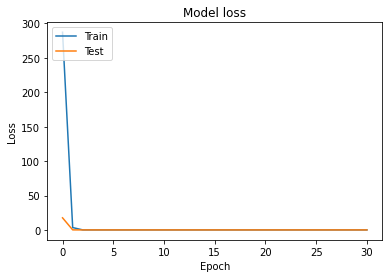

验证集上的最优结果是3.752345219254494e-05,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 256)               607488    
                                                                 
 dense_95 (Dense)            (None, 256)               65792     
                                                                 
 dense_96 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 124.8510 - JI: 0.0232 - val_loss: 4.1695 - val_JI: 0.0017
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 1.3542 - JI: 0

Epoch 54/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8310 - JI: 0.0452 - val_loss: 0.8260 - val_JI: 0.0447
Epoch 55/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8294 - JI: 0.0459 - val_loss: 0.8241 - val_JI: 0.0461
Epoch 56/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8304 - JI: 0.0466 - val_loss: 0.8282 - val_JI: 0.0470
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8294 - JI: 0.0473 - val_loss: 0.8277 - val_JI: 0.0513
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8265 - JI: 0.0484 - val_loss: 0.8258 - val_JI: 0.0480
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.8285 - JI: 0.0492 - val_loss: 0.8242 - val_JI: 0.0473
Epoch 60/500
110/110 [==============================] - 1s 8ms/step - loss: 0.8261 - JI: 0.0498 - val_loss: 0.8305 - val_JI: 0.0457
Epoch 61/500
110/110 [==============================] - 1s 8ms/step - loss: 

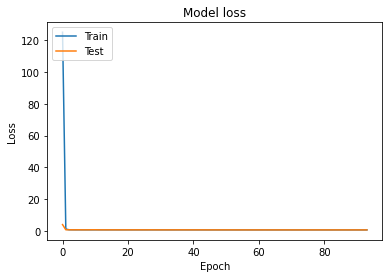

验证集上的最优结果是0.061928290873765945,对应训练轮次是78
create model. feature_dim =2372, label_dim =300
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 256)               607488    
                                                                 
 dense_98 (Dense)            (None, 256)               65792     
                                                                 
 dense_99 (Dense)            (None, 256)               65792     
                                                                 
 dense_100 (Dense)           (None, 256)               65792     
                                                                 
 dense_101 (Dense)           (None, 256)               65792     
                                                                 
 dense_102 (Dense)           (None, 300)               77100     
                              

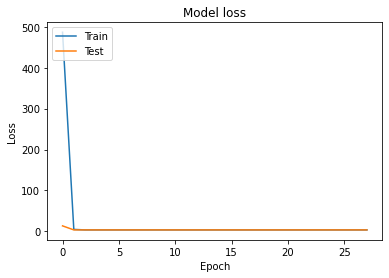

验证集上的最优结果是0.07303398102521896,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 256)               607488    
                                                                 
 dense_104 (Dense)           (None, 256)               65792     
                                                                 
 dense_105 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 16ms/step - loss: 9.5834 - JI: 0.0265 - val_loss: 1.9297 - val_JI: 0.0197
Epoch 2/500
110/110 [==============================] - 1s 12ms/step - loss: 0.8882 - JI: 0.0

Epoch 56/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0901 - JI: 0.1058 - val_loss: 0.0901 - val_JI: 0.1016
Epoch 57/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0912 - JI: 0.1057 - val_loss: 0.0921 - val_JI: 0.0936
Epoch 58/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0909 - JI: 0.1064 - val_loss: 0.0901 - val_JI: 0.0889
Epoch 59/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0898 - JI: 0.1083 - val_loss: 0.0897 - val_JI: 0.0959
Epoch 60/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0900 - JI: 0.1078 - val_loss: 0.0897 - val_JI: 0.1147
Epoch 61/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0902 - JI: 0.1084 - val_loss: 0.0944 - val_JI: 0.1065
Epoch 62/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0910 - JI: 0.1089 - val_loss: 0.0925 - val_JI: 0.1029
Epoch 63/500
110/110 [==============================] - 1s 12ms/step 

110/110 [==============================] - 1s 8ms/step - loss: 0.0824 - JI: 0.1557 - val_loss: 0.0841 - val_JI: 0.1309
Epoch 179/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0823 - JI: 0.1557 - val_loss: 0.0837 - val_JI: 0.1476
Epoch 180/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0823 - JI: 0.1552 - val_loss: 0.0838 - val_JI: 0.1465
Epoch 181/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0822 - JI: 0.1560 - val_loss: 0.0839 - val_JI: 0.1533
Epoch 182/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0822 - JI: 0.1573 - val_loss: 0.0835 - val_JI: 0.1455
Epoch 183/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0823 - JI: 0.1562 - val_loss: 0.0837 - val_JI: 0.1489
Epoch 184/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0824 - JI: 0.1554 - val_loss: 0.0838 - val_JI: 0.1452
Epoch 185/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0822

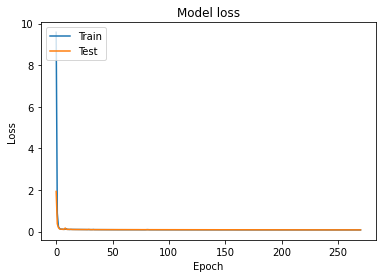

验证集上的最优结果是0.16641992330551147,对应训练轮次是208
create model. feature_dim =2372, label_dim =300
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 256)               607488    
                                                                 
 dense_107 (Dense)           (None, 256)               65792     
                                                                 
 dense_108 (Dense)           (None, 256)               65792     
                                                                 
 dense_109 (Dense)           (None, 256)               65792     
                                                                 
 dense_110 (Dense)           (None, 256)               65792     
                                                                 
 dense_111 (Dense)           (None, 300)               77100     
                              

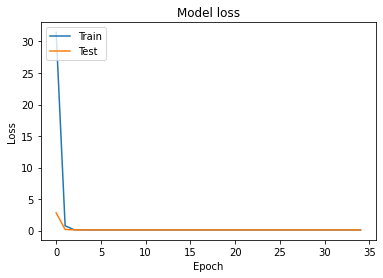

验证集上的最优结果是0.0,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 256)               607488    
                                                                 
 dense_113 (Dense)           (None, 256)               65792     
                                                                 
 dense_114 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 16ms/step - loss: 17.8002 - JI: 0.0281 - val_loss: 5.7637 - val_JI: 0.0228
Epoch 2/500
110/110 [==============================] - 1s 13ms/step - loss: 3.1707 - JI: 0.0117 - val_loss:

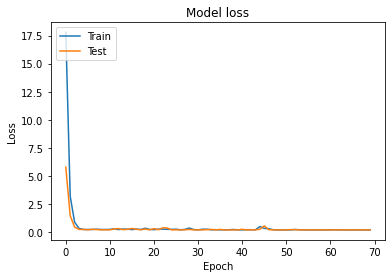

验证集上的最优结果是0.06812800467014313,对应训练轮次是52
create model. feature_dim =2372, label_dim =300
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 256)               607488    
                                                                 
 dense_116 (Dense)           (None, 256)               65792     
                                                                 
 dense_117 (Dense)           (None, 256)               65792     
                                                                 
 dense_118 (Dense)           (None, 256)               65792     
                                                                 
 dense_119 (Dense)           (None, 256)               65792     
                                                                 
 dense_120 (Dense)           (None, 300)               77100     
                               

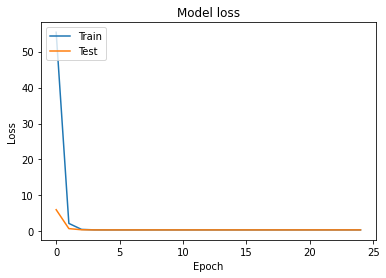

验证集上的最优结果是0.001775694778189063,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_121 (Dense)           (None, 256)               607488    
                                                                 
 dense_122 (Dense)           (None, 256)               65792     
                                                                 
 dense_123 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 2s 10ms/step - loss: 1.6182 - JI: 0.0283 - val_loss: 0.7186 - val_JI: 0.0287
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 0.5839 - JI: 0.0

Epoch 56/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0837 - JI: 0.1509 - val_loss: 0.0844 - val_JI: 0.1381
Epoch 57/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0831 - JI: 0.1530 - val_loss: 0.0843 - val_JI: 0.1361
Epoch 58/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0831 - JI: 0.1532 - val_loss: 0.0846 - val_JI: 0.1521
Epoch 59/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0828 - JI: 0.1557 - val_loss: 0.0838 - val_JI: 0.1418
Epoch 60/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0828 - JI: 0.1559 - val_loss: 0.0841 - val_JI: 0.1302
Epoch 61/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0829 - JI: 0.1548 - val_loss: 0.0836 - val_JI: 0.1557
Epoch 62/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0828 - JI: 0.1563 - val_loss: 0.0841 - val_JI: 0.1443
Epoch 63/500
110/110 [==============================] - 1s 14ms/step 

Epoch 117/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0795 - JI: 0.1852 - val_loss: 0.0818 - val_JI: 0.1592
Epoch 118/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0793 - JI: 0.1857 - val_loss: 0.0829 - val_JI: 0.1829
Epoch 119/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0793 - JI: 0.1839 - val_loss: 0.0831 - val_JI: 0.1598
Epoch 120/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0794 - JI: 0.1845 - val_loss: 0.0816 - val_JI: 0.1493
Epoch 121/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0788 - JI: 0.1874 - val_loss: 0.0813 - val_JI: 0.1706
Epoch 122/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0791 - JI: 0.1860 - val_loss: 0.0810 - val_JI: 0.1696
Epoch 123/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0785 - JI: 0.1887 - val_loss: 0.0809 - val_JI: 0.1732
Epoch 124/500
110/110 [==============================] - 1s 13

110/110 [==============================] - 1s 13ms/step - loss: 0.0753 - JI: 0.2144 - val_loss: 0.0809 - val_JI: 0.1801
Epoch 240/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0769 - JI: 0.2048 - val_loss: 0.0822 - val_JI: 0.1722


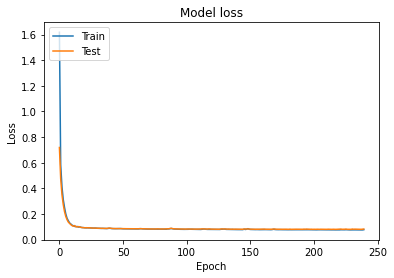

验证集上的最优结果是0.1983029693365097,对应训练轮次是179
create model. feature_dim =2372, label_dim =300
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_124 (Dense)           (None, 256)               607488    
                                                                 
 dense_125 (Dense)           (None, 256)               65792     
                                                                 
 dense_126 (Dense)           (None, 256)               65792     
                                                                 
 dense_127 (Dense)           (None, 256)               65792     
                                                                 
 dense_128 (Dense)           (None, 256)               65792     
                                                                 
 dense_129 (Dense)           (None, 300)               77100     
                               

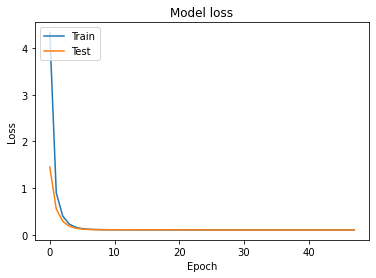

验证集上的最优结果是0.0,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 256)               607488    
                                                                 
 dense_131 (Dense)           (None, 256)               65792     
                                                                 
 dense_132 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 15ms/step - loss: 2.2736 - JI: 0.0243 - val_loss: 1.0258 - val_JI: 0.0381
Epoch 2/500
110/110 [==============================] - 1s 12ms/step - loss: 0.9109 - JI: 0.0156 - val_loss: 

Epoch 56/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0956 - JI: 0.1296 - val_loss: 0.0968 - val_JI: 0.1247
Epoch 57/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0951 - JI: 0.1290 - val_loss: 0.0947 - val_JI: 0.1343
Epoch 58/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0940 - JI: 0.1315 - val_loss: 0.0963 - val_JI: 0.1182
Epoch 59/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0942 - JI: 0.1297 - val_loss: 0.0950 - val_JI: 0.1268
Epoch 60/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0945 - JI: 0.1329 - val_loss: 0.1001 - val_JI: 0.1207
Epoch 61/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1010 - JI: 0.1305 - val_loss: 0.0988 - val_JI: 0.0967
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0958 - JI: 0.1294 - val_loss: 0.0952 - val_JI: 0.1228
Epoch 63/500
110/110 [==============================] - 1s 8ms/step - lo

110/110 [==============================] - 1s 12ms/step - loss: 0.0899 - JI: 0.1669 - val_loss: 0.0960 - val_JI: 0.1497
Epoch 179/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0914 - JI: 0.1653 - val_loss: 0.0919 - val_JI: 0.1484
Epoch 180/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0901 - JI: 0.1676 - val_loss: 0.0930 - val_JI: 0.1612
Epoch 181/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0897 - JI: 0.1655 - val_loss: 0.0913 - val_JI: 0.1448
Epoch 182/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0894 - JI: 0.1666 - val_loss: 0.0916 - val_JI: 0.1435
Epoch 183/500
110/110 [==============================] - 1s 13ms/step - loss: 0.0891 - JI: 0.1679 - val_loss: 0.0911 - val_JI: 0.1444
Epoch 184/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0893 - JI: 0.1682 - val_loss: 0.0918 - val_JI: 0.1697
Epoch 185/500
110/110 [==============================] - 1s 12ms/step - loss

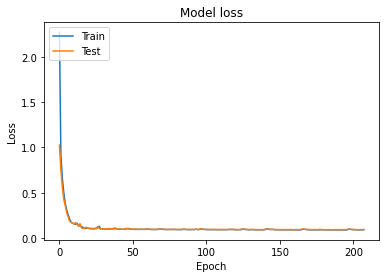

验证集上的最优结果是0.16965046525001526,对应训练轮次是184
create model. feature_dim =2372, label_dim =300
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 256)               607488    
                                                                 
 dense_134 (Dense)           (None, 256)               65792     
                                                                 
 dense_135 (Dense)           (None, 256)               65792     
                                                                 
 dense_136 (Dense)           (None, 256)               65792     
                                                                 
 dense_137 (Dense)           (None, 256)               65792     
                                                                 
 dense_138 (Dense)           (None, 300)               77100     
                              

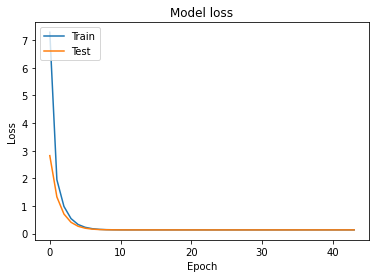

验证集上的最优结果是0.0,对应训练轮次是1
create model. feature_dim =2372, label_dim =300
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 256)               607488    
                                                                 
 dense_140 (Dense)           (None, 256)               65792     
                                                                 
 dense_141 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 15ms/step - loss: 0.5525 - JI: 0.0313 - val_loss: 0.2147 - val_JI: 0.0261
Epoch 2/500
110/110 [==============================] - 1s 11ms/step - loss: 0.2077 - JI: 0.0315 - val_loss: 

110/110 [==============================] - 1s 12ms/step - loss: 0.0746 - JI: 0.2240 - val_loss: 0.0796 - val_JI: 0.1912
Epoch 117/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0744 - JI: 0.2240 - val_loss: 0.0794 - val_JI: 0.1888
Epoch 118/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0741 - JI: 0.2267 - val_loss: 0.0794 - val_JI: 0.1999
Epoch 119/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0742 - JI: 0.2262 - val_loss: 0.0795 - val_JI: 0.1877
Epoch 120/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0748 - JI: 0.2216 - val_loss: 0.0800 - val_JI: 0.1749
Epoch 121/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0742 - JI: 0.2254 - val_loss: 0.0795 - val_JI: 0.1738
Epoch 122/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0740 - JI: 0.2268 - val_loss: 0.0794 - val_JI: 0.1966
Epoch 123/500
110/110 [==============================] - 1s 11ms/step - loss

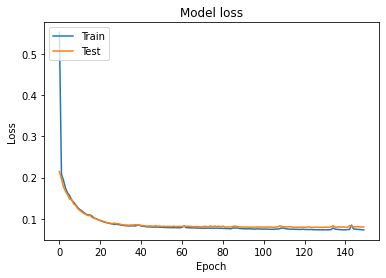

验证集上的最优结果是0.20812144875526428,对应训练轮次是138
create model. feature_dim =2372, label_dim =300
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_142 (Dense)           (None, 256)               607488    
                                                                 
 dense_143 (Dense)           (None, 256)               65792     
                                                                 
 dense_144 (Dense)           (None, 256)               65792     
                                                                 
 dense_145 (Dense)           (None, 256)               65792     
                                                                 
 dense_146 (Dense)           (None, 256)               65792     
                                                                 
 dense_147 (Dense)           (None, 300)               77100     
                              

110/110 [==============================] - 2s 16ms/step - loss: 0.0869 - JI: 0.1387 - val_loss: 0.0878 - val_JI: 0.1298
Epoch 114/500
110/110 [==============================] - 2s 16ms/step - loss: 0.0868 - JI: 0.1399 - val_loss: 0.0878 - val_JI: 0.1333
Epoch 115/500
110/110 [==============================] - 2s 18ms/step - loss: 0.0867 - JI: 0.1400 - val_loss: 0.0876 - val_JI: 0.1376
Epoch 116/500
110/110 [==============================] - 2s 16ms/step - loss: 0.0866 - JI: 0.1404 - val_loss: 0.0875 - val_JI: 0.1323
Epoch 117/500
110/110 [==============================] - 2s 17ms/step - loss: 0.0867 - JI: 0.1404 - val_loss: 0.0881 - val_JI: 0.1385
Epoch 118/500
110/110 [==============================] - 2s 15ms/step - loss: 0.0866 - JI: 0.1411 - val_loss: 0.0877 - val_JI: 0.1414
Epoch 119/500
110/110 [==============================] - 2s 16ms/step - loss: 0.0870 - JI: 0.1388 - val_loss: 0.0890 - val_JI: 0.1386
Epoch 120/500
110/110 [==============================] - 2s 15ms/step - loss

110/110 [==============================] - 2s 15ms/step - loss: 0.0840 - JI: 0.1568 - val_loss: 0.0858 - val_JI: 0.1581
Epoch 236/500
110/110 [==============================] - 2s 15ms/step - loss: 0.0836 - JI: 0.1599 - val_loss: 0.0855 - val_JI: 0.1471
Epoch 237/500
110/110 [==============================] - 2s 15ms/step - loss: 0.0835 - JI: 0.1602 - val_loss: 0.0854 - val_JI: 0.1538
Epoch 238/500
110/110 [==============================] - 2s 14ms/step - loss: 0.0835 - JI: 0.1602 - val_loss: 0.0860 - val_JI: 0.1514
Epoch 239/500
110/110 [==============================] - 2s 15ms/step - loss: 0.0835 - JI: 0.1604 - val_loss: 0.0857 - val_JI: 0.1628
Epoch 240/500
110/110 [==============================] - 2s 14ms/step - loss: 0.0835 - JI: 0.1611 - val_loss: 0.0857 - val_JI: 0.1534
Epoch 241/500
110/110 [==============================] - 2s 14ms/step - loss: 0.0838 - JI: 0.1603 - val_loss: 0.0858 - val_JI: 0.1461
Epoch 242/500
110/110 [==============================] - 2s 14ms/step - loss

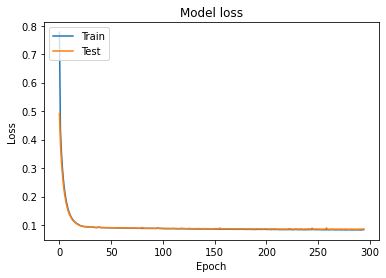

验证集上的最优结果是0.16276980936527252,对应训练轮次是239
create model. feature_dim =2372, label_dim =300
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 256)               607488    
                                                                 
 dense_149 (Dense)           (None, 256)               65792     
                                                                 
 dense_150 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 16ms/step - loss: 0.6840 - JI: 0.0306 - val_loss: 0.2756 - val_JI: 0.0165
Epoch 2/500
110/110 [==============================] - 1s 12ms/step - loss: 0.2690 - JI: 0

Epoch 56/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0863 - JI: 0.1717 - val_loss: 0.0880 - val_JI: 0.1421
Epoch 57/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0858 - JI: 0.1740 - val_loss: 0.0864 - val_JI: 0.1534
Epoch 58/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0833 - JI: 0.1771 - val_loss: 0.0855 - val_JI: 0.1687
Epoch 59/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0841 - JI: 0.1740 - val_loss: 0.0852 - val_JI: 0.1544
Epoch 60/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0823 - JI: 0.1786 - val_loss: 0.0842 - val_JI: 0.1642
Epoch 61/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0827 - JI: 0.1752 - val_loss: 0.0848 - val_JI: 0.1592
Epoch 62/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0817 - JI: 0.1787 - val_loss: 0.0837 - val_JI: 0.1633
Epoch 63/500
110/110 [==============================] - 1s 13ms/step 

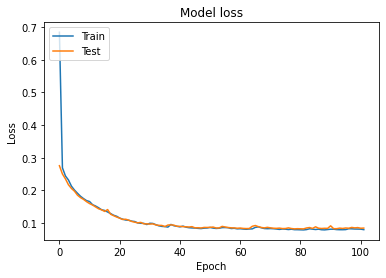

验证集上的最优结果是0.19281411170959473,对应训练轮次是80
create model. feature_dim =2372, label_dim =300
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_151 (Dense)           (None, 256)               607488    
                                                                 
 dense_152 (Dense)           (None, 256)               65792     
                                                                 
 dense_153 (Dense)           (None, 256)               65792     
                                                                 
 dense_154 (Dense)           (None, 256)               65792     
                                                                 
 dense_155 (Dense)           (None, 256)               65792     
                                                                 
 dense_156 (Dense)           (None, 300)               77100     
                               

Epoch 53/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0932 - JI: 0.1164 - val_loss: 0.0933 - val_JI: 0.1084
Epoch 54/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0929 - JI: 0.1164 - val_loss: 0.0932 - val_JI: 0.1123
Epoch 55/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0927 - JI: 0.1178 - val_loss: 0.0932 - val_JI: 0.1139
Epoch 56/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0929 - JI: 0.1173 - val_loss: 0.0934 - val_JI: 0.1106
Epoch 57/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0928 - JI: 0.1179 - val_loss: 0.0931 - val_JI: 0.1096
Epoch 58/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0926 - JI: 0.1183 - val_loss: 0.0929 - val_JI: 0.1129
Epoch 59/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0926 - JI: 0.1181 - val_loss: 0.0931 - val_JI: 0.1141
Epoch 60/500
110/110 [==============================] - 1s 10ms/step - lo

Epoch 115/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0903 - JI: 0.1322 - val_loss: 0.0925 - val_JI: 0.1357
Epoch 116/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0907 - JI: 0.1311 - val_loss: 0.0913 - val_JI: 0.1198
Epoch 117/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0903 - JI: 0.1327 - val_loss: 0.0916 - val_JI: 0.1167
Epoch 118/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0902 - JI: 0.1333 - val_loss: 0.0914 - val_JI: 0.1226
Epoch 119/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0901 - JI: 0.1341 - val_loss: 0.0914 - val_JI: 0.1145
Epoch 120/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0904 - JI: 0.1326 - val_loss: 0.0911 - val_JI: 0.1244
Epoch 121/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0902 - JI: 0.1344 - val_loss: 0.0913 - val_JI: 0.1214
Epoch 122/500
110/110 [==============================] - 1s 10

110/110 [==============================] - 1s 10ms/step - loss: 0.0886 - JI: 0.1474 - val_loss: 0.0899 - val_JI: 0.1402
Epoch 238/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0880 - JI: 0.1500 - val_loss: 0.0914 - val_JI: 0.1447
Epoch 239/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0880 - JI: 0.1505 - val_loss: 0.0903 - val_JI: 0.1347
Epoch 240/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0880 - JI: 0.1512 - val_loss: 0.0899 - val_JI: 0.1508
Epoch 241/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0879 - JI: 0.1511 - val_loss: 0.0895 - val_JI: 0.1387
Epoch 242/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0891 - JI: 0.1433 - val_loss: 0.0899 - val_JI: 0.1247
Epoch 243/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0887 - JI: 0.1461 - val_loss: 0.0899 - val_JI: 0.1384
Epoch 244/500
110/110 [==============================] - 1s 9ms/step - loss: 0.

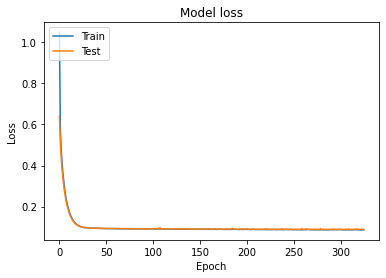

验证集上的最优结果是0.15103186666965485,对应训练轮次是320
create model. feature_dim =2372, label_dim =300
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 256)               607488    
                                                                 
 dense_158 (Dense)           (None, 256)               65792     
                                                                 
 dense_159 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4106 - JI: 0.0305 - val_loss: 0.1285 - val_JI: 0.0289
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1325 - JI: 0.0

Epoch 56/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0800 - JI: 0.1926 - val_loss: 0.0818 - val_JI: 0.1743
Epoch 57/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0788 - JI: 0.2001 - val_loss: 0.0822 - val_JI: 0.1664
Epoch 58/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0784 - JI: 0.2033 - val_loss: 0.0816 - val_JI: 0.1914
Epoch 59/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0771 - JI: 0.2077 - val_loss: 0.0810 - val_JI: 0.1786
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0771 - JI: 0.2068 - val_loss: 0.0818 - val_JI: 0.1995
Epoch 61/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0770 - JI: 0.2080 - val_loss: 0.0808 - val_JI: 0.1785
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0769 - JI: 0.2085 - val_loss: 0.0808 - val_JI: 0.1897
Epoch 63/500
110/110 [==============================] - 1s 8ms/step - loss: 

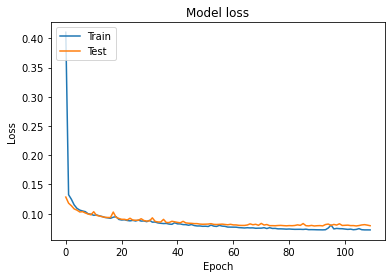

验证集上的最优结果是0.20782843232154846,对应训练轮次是106
create model. feature_dim =2372, label_dim =300
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 256)               607488    
                                                                 
 dense_161 (Dense)           (None, 256)               65792     
                                                                 
 dense_162 (Dense)           (None, 256)               65792     
                                                                 
 dense_163 (Dense)           (None, 256)               65792     
                                                                 
 dense_164 (Dense)           (None, 256)               65792     
                                                                 
 dense_165 (Dense)           (None, 300)               77100     
                              

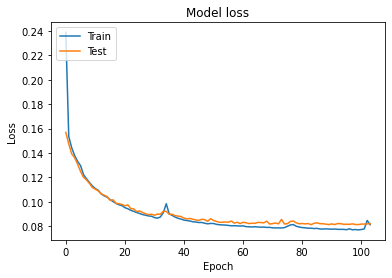

验证集上的最优结果是0.20051857829093933,对应训练轮次是93
create model. feature_dim =2372, label_dim =300
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 256)               607488    
                                                                 
 dense_167 (Dense)           (None, 256)               65792     
                                                                 
 dense_168 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.4423 - JI: 0.0291 - val_loss: 0.1309 - val_JI: 0.0259
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1379 - JI: 0.02

110/110 [==============================] - 1s 8ms/step - loss: 0.0744 - JI: 0.2315 - val_loss: 0.0805 - val_JI: 0.1852
Epoch 119/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0741 - JI: 0.2319 - val_loss: 0.0817 - val_JI: 0.1955
Epoch 120/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0737 - JI: 0.2347 - val_loss: 0.0808 - val_JI: 0.2003
Epoch 121/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0734 - JI: 0.2372 - val_loss: 0.0824 - val_JI: 0.1988
Epoch 122/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0744 - JI: 0.2295 - val_loss: 0.0806 - val_JI: 0.1968
Epoch 123/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0749 - JI: 0.2284 - val_loss: 0.0812 - val_JI: 0.1787
Epoch 124/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0734 - JI: 0.2349 - val_loss: 0.0808 - val_JI: 0.1933
Epoch 125/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0731

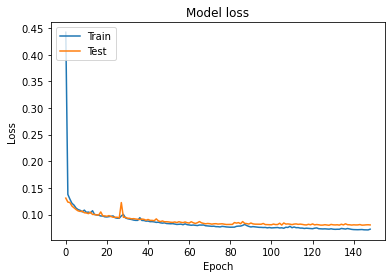

验证集上的最优结果是0.20941366255283356,对应训练轮次是147
create model. feature_dim =2372, label_dim =300
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_169 (Dense)           (None, 256)               607488    
                                                                 
 dense_170 (Dense)           (None, 256)               65792     
                                                                 
 dense_171 (Dense)           (None, 256)               65792     
                                                                 
 dense_172 (Dense)           (None, 256)               65792     
                                                                 
 dense_173 (Dense)           (None, 256)               65792     
                                                                 
 dense_174 (Dense)           (None, 300)               77100     
                              

Epoch 115/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0771 - JI: 0.2163 - val_loss: 0.0840 - val_JI: 0.1751
Epoch 116/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0773 - JI: 0.2144 - val_loss: 0.0821 - val_JI: 0.1843


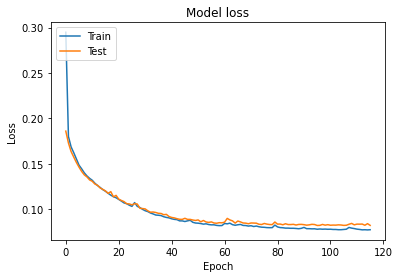

验证集上的最优结果是0.19623875617980957,对应训练轮次是111
create model. feature_dim =2372, label_dim =300
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 256)               607488    
                                                                 
 dense_176 (Dense)           (None, 256)               65792     
                                                                 
 dense_177 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.4626 - JI: 0.0334 - val_loss: 0.1168 - val_JI: 0.0261
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1307 - JI: 0.0

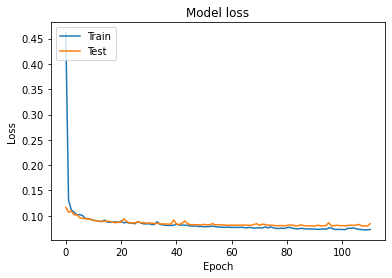

验证集上的最优结果是0.20339356362819672,对应训练轮次是93
create model. feature_dim =2372, label_dim =300
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 256)               607488    
                                                                 
 dense_179 (Dense)           (None, 256)               65792     
                                                                 
 dense_180 (Dense)           (None, 256)               65792     
                                                                 
 dense_181 (Dense)           (None, 256)               65792     
                                                                 
 dense_182 (Dense)           (None, 256)               65792     
                                                                 
 dense_183 (Dense)           (None, 300)               77100     
                               

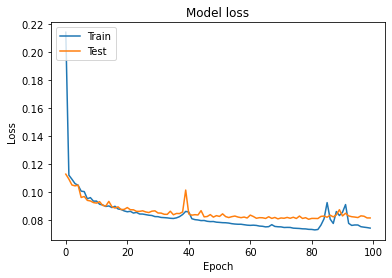

验证集上的最优结果是0.20363514125347137,对应训练轮次是66
create model. feature_dim =2372, label_dim =300
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 256)               607488    
                                                                 
 dense_185 (Dense)           (None, 256)               65792     
                                                                 
 dense_186 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.4229 - JI: 0.0317 - val_loss: 0.1166 - val_JI: 0.0204
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1290 - JI: 0.02

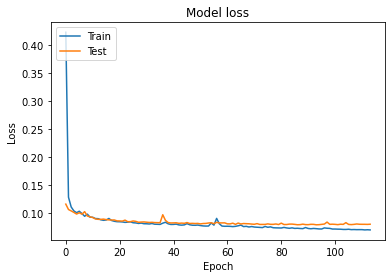

验证集上的最优结果是0.206843301653862,对应训练轮次是81
create model. feature_dim =2372, label_dim =300
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_187 (Dense)           (None, 256)               607488    
                                                                 
 dense_188 (Dense)           (None, 256)               65792     
                                                                 
 dense_189 (Dense)           (None, 256)               65792     
                                                                 
 dense_190 (Dense)           (None, 256)               65792     
                                                                 
 dense_191 (Dense)           (None, 256)               65792     
                                                                 
 dense_192 (Dense)           (None, 300)               77100     
                                 

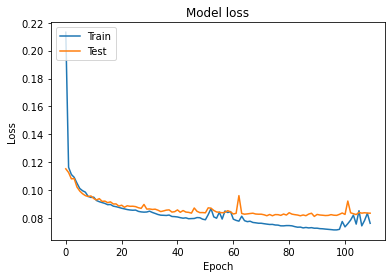

验证集上的最优结果是0.2063404619693756,对应训练轮次是92
create model. feature_dim =2372, label_dim =300
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_193 (Dense)           (None, 256)               607488    
                                                                 
 dense_194 (Dense)           (None, 256)               65792     
                                                                 
 dense_195 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.3476 - JI: 0.0348 - val_loss: 0.1114 - val_JI: 0.0404
Epoch 2/500
110/110 [==============================] - 1s 7ms/step - loss: 0.1120 - JI: 0.041

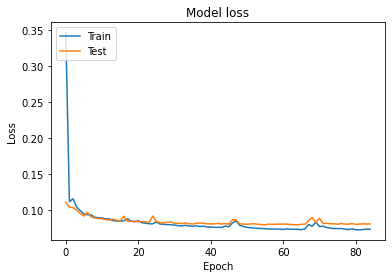

验证集上的最优结果是0.20571479201316833,对应训练轮次是61
create model. feature_dim =2372, label_dim =300
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_196 (Dense)           (None, 256)               607488    
                                                                 
 dense_197 (Dense)           (None, 256)               65792     
                                                                 
 dense_198 (Dense)           (None, 256)               65792     
                                                                 
 dense_199 (Dense)           (None, 256)               65792     
                                                                 
 dense_200 (Dense)           (None, 256)               65792     
                                                                 
 dense_201 (Dense)           (None, 300)               77100     
                               

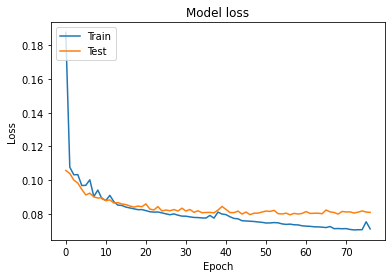

验证集上的最优结果是0.20210658013820648,对应训练轮次是70


[0.06635604798793793,
 0.052160222083330154,
 0.1610405147075653,
 3.752345219254494e-05,
 0.061928290873765945,
 0.07303398102521896,
 0.16641992330551147,
 0.0,
 0.06812800467014313,
 0.001775694778189063,
 0.1983029693365097,
 0.0,
 0.16965046525001526,
 0.0,
 0.20812144875526428,
 0.16276980936527252,
 0.19281411170959473,
 0.15103186666965485,
 0.20782843232154846,
 0.20051857829093933,
 0.20941366255283356,
 0.19623875617980957,
 0.20339356362819672,
 0.20363514125347137,
 0.206843301653862,
 0.2063404619693756,
 0.20571479201316833,
 0.20210658013820648]

In [9]:
results = []
# 调正则化参数及隐层层数
for re in kernel_regularizer_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],use_kernel_regularizer = True,kernel_regularizer = re))
    results.append(train_DNN(X_train,y_train,X_test,y_test,callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],hidden_layer_num = 4,use_kernel_regularizer = True,kernel_regularizer = re))
results
    


create model. feature_dim =2372, label_dim =300
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_229 (Dense)           (None, 256)               607488    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_230 (Dense)           (None, 256)               65792     
                                                                 
 dense_231 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 3s 17ms/step - loss: 0.5837 - JI: 0.0332 - val_loss: 0.1384 - val_JI: 0.0152

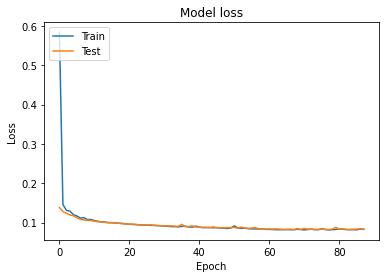

验证集上的最优结果是0.17751532793045044,对应训练轮次是78
create model. feature_dim =2372, label_dim =300
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_232 (Dense)           (None, 256)               607488    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_233 (Dense)           (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_234 (Dense)           (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                               

Epoch 49/500
110/110 [==============================] - 2s 19ms/step - loss: 0.0917 - JI: 0.1348 - val_loss: 0.0926 - val_JI: 0.1401
Epoch 50/500
110/110 [==============================] - 2s 20ms/step - loss: 0.0912 - JI: 0.1331 - val_loss: 0.0916 - val_JI: 0.1405
Epoch 51/500
110/110 [==============================] - 2s 20ms/step - loss: 0.0911 - JI: 0.1329 - val_loss: 0.0919 - val_JI: 0.1219
Epoch 52/500
110/110 [==============================] - 2s 20ms/step - loss: 0.0908 - JI: 0.1325 - val_loss: 0.0910 - val_JI: 0.1345
Epoch 53/500
110/110 [==============================] - 2s 21ms/step - loss: 0.0902 - JI: 0.1350 - val_loss: 0.0908 - val_JI: 0.1204
Epoch 54/500
110/110 [==============================] - 2s 20ms/step - loss: 0.0895 - JI: 0.1363 - val_loss: 0.0906 - val_JI: 0.1332
Epoch 55/500
110/110 [==============================] - 2s 20ms/step - loss: 0.0890 - JI: 0.1388 - val_loss: 0.0892 - val_JI: 0.1306
Epoch 56/500
110/110 [==============================] - 2s 20ms/step 

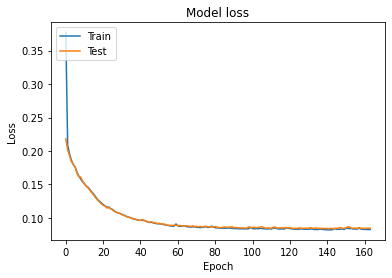

验证集上的最优结果是0.18390193581581116,对应训练轮次是119
create model. feature_dim =2372, label_dim =300
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 256)               607488    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_239 (Dense)           (None, 256)               65792     
                                                                 
 dense_240 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.5598 - JI: 0.

110/110 [==============================] - 1s 8ms/step - loss: 0.0849 - JI: 0.1372 - val_loss: 0.0883 - val_JI: 0.1226
Epoch 118/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0855 - JI: 0.1324 - val_loss: 0.0849 - val_JI: 0.1471
Epoch 119/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0836 - JI: 0.1435 - val_loss: 0.0835 - val_JI: 0.1406
Epoch 120/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0836 - JI: 0.1459 - val_loss: 0.0843 - val_JI: 0.1414
Epoch 121/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0839 - JI: 0.1454 - val_loss: 0.0842 - val_JI: 0.1407
Epoch 122/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0840 - JI: 0.1462 - val_loss: 0.0868 - val_JI: 0.1281
Epoch 123/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0852 - JI: 0.1344 - val_loss: 0.0849 - val_JI: 0.1393
Epoch 124/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0850

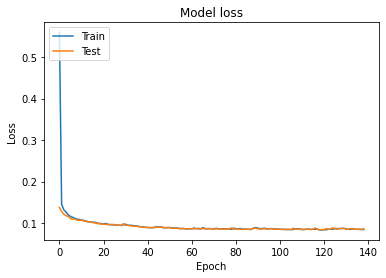

验证集上的最优结果是0.15807382762432098,对应训练轮次是42
create model. feature_dim =2372, label_dim =300
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_241 (Dense)           (None, 256)               607488    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_242 (Dense)           (None, 256)               65792     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_243 (Dense)           (None, 256)               65792     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                               

Epoch 49/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0908 - JI: 0.1151 - val_loss: 0.0904 - val_JI: 0.1351
Epoch 50/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0904 - JI: 0.1188 - val_loss: 0.0908 - val_JI: 0.1111
Epoch 51/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0900 - JI: 0.1179 - val_loss: 0.0894 - val_JI: 0.1219
Epoch 52/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0902 - JI: 0.1147 - val_loss: 0.0897 - val_JI: 0.1396
Epoch 53/500
110/110 [==============================] - 1s 10ms/step - loss: 0.0894 - JI: 0.1199 - val_loss: 0.0892 - val_JI: 0.1151
Epoch 54/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0905 - JI: 0.1191 - val_loss: 0.0907 - val_JI: 0.1051
Epoch 55/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0908 - JI: 0.1161 - val_loss: 0.0901 - val_JI: 0.1252
Epoch 56/500
110/110 [==============================] - 1s 11ms/step 

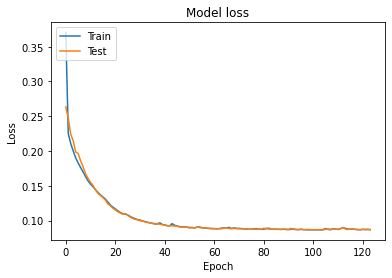

验证集上的最优结果是0.15606428682804108,对应训练轮次是117
create model. feature_dim =2372, label_dim =300
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_247 (Dense)           (None, 256)               607488    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_248 (Dense)           (None, 256)               65792     
                                                                 
 dense_249 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 8ms/step - loss: 0.5820 - JI: 0.

Epoch 55/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0893 - JI: 0.1204 - val_loss: 0.0920 - val_JI: 0.1477
Epoch 56/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0966 - JI: 0.1254 - val_loss: 0.0903 - val_JI: 0.1564
Epoch 57/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0900 - JI: 0.1231 - val_loss: 0.0901 - val_JI: 0.1400
Epoch 58/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0902 - JI: 0.1192 - val_loss: 0.0914 - val_JI: 0.1416
Epoch 59/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0898 - JI: 0.1196 - val_loss: 0.0913 - val_JI: 0.1354
Epoch 60/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0901 - JI: 0.1168 - val_loss: 0.0914 - val_JI: 0.1448
Epoch 61/500
110/110 [==============================] - 1s 7ms/step - loss: 0.0892 - JI: 0.1201 - val_loss: 0.0904 - val_JI: 0.1530
Epoch 62/500
110/110 [==============================] - 1s 7ms/step - loss: 

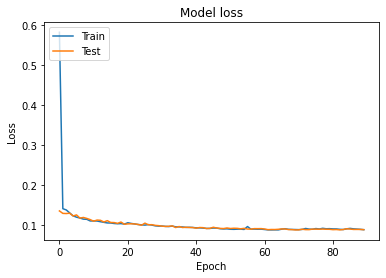

验证集上的最优结果是0.16155388951301575,对应训练轮次是15
create model. feature_dim =2372, label_dim =300
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_250 (Dense)           (None, 256)               607488    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_251 (Dense)           (None, 256)               65792     
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_252 (Dense)           (None, 256)               65792     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                               

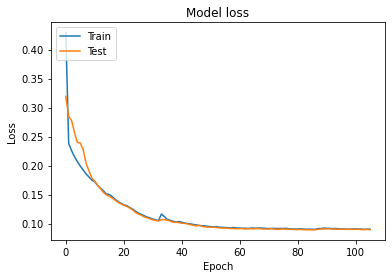

验证集上的最优结果是0.13064393401145935,对应训练轮次是106
create model. feature_dim =2372, label_dim =300
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_256 (Dense)           (None, 256)               607488    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_257 (Dense)           (None, 256)               65792     
                                                                 
 dense_258 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 10ms/step - loss: 0.6606 - JI: 0

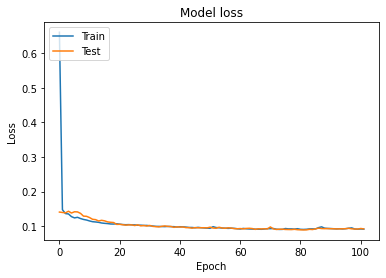

验证集上的最优结果是0.1431455761194229,对应训练轮次是12
create model. feature_dim =2372, label_dim =300
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_259 (Dense)           (None, 256)               607488    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_260 (Dense)           (None, 256)               65792     
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_261 (Dense)           (None, 256)               65792     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                

110/110 [==============================] - 1s 12ms/step - loss: 0.0921 - JI: 0.0921 - val_loss: 0.0916 - val_JI: 0.0964
Epoch 110/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0921 - JI: 0.0922 - val_loss: 0.0913 - val_JI: 0.1066
Epoch 111/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0925 - JI: 0.0911 - val_loss: 0.0915 - val_JI: 0.0978
Epoch 112/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0926 - JI: 0.0914 - val_loss: 0.0916 - val_JI: 0.1081
Epoch 113/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0923 - JI: 0.0918 - val_loss: 0.0917 - val_JI: 0.1107
Epoch 114/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0923 - JI: 0.0929 - val_loss: 0.0913 - val_JI: 0.1015
Epoch 115/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0921 - JI: 0.0923 - val_loss: 0.0916 - val_JI: 0.1004
Epoch 116/500
110/110 [==============================] - 1s 11ms/step - loss

Epoch 170/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0910 - JI: 0.0986 - val_loss: 0.0903 - val_JI: 0.1141
Epoch 171/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0913 - JI: 0.0978 - val_loss: 0.0902 - val_JI: 0.1064
Epoch 172/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0909 - JI: 0.0996 - val_loss: 0.0903 - val_JI: 0.1179
Epoch 173/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0914 - JI: 0.0973 - val_loss: 0.0914 - val_JI: 0.1087
Epoch 174/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0910 - JI: 0.0995 - val_loss: 0.0905 - val_JI: 0.1017
Epoch 175/500
110/110 [==============================] - 1s 11ms/step - loss: 0.0909 - JI: 0.0991 - val_loss: 0.0900 - val_JI: 0.1183
Epoch 176/500
110/110 [==============================] - 1s 12ms/step - loss: 0.0908 - JI: 0.1006 - val_loss: 0.0908 - val_JI: 0.1243
Epoch 177/500
110/110 [==============================] - 1s 12

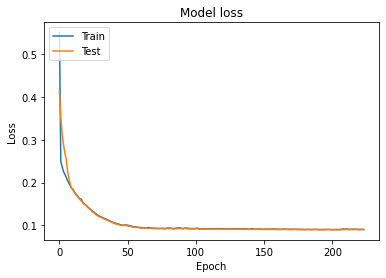

验证集上的最优结果是0.12437869608402252,对应训练轮次是222
create model. feature_dim =2372, label_dim =300
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_265 (Dense)           (None, 256)               607488    
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_266 (Dense)           (None, 256)               65792     
                                                                 
 dense_267 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 9ms/step - loss: 0.6236 - JI: 0.

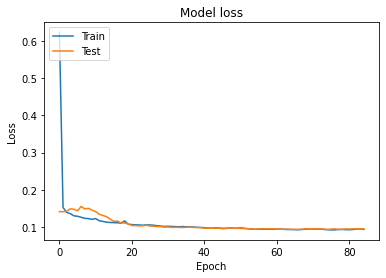

验证集上的最优结果是0.15302088856697083,对应训练轮次是13
create model. feature_dim =2372, label_dim =300
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_268 (Dense)           (None, 256)               607488    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_269 (Dense)           (None, 256)               65792     
                                                                 
 dropout_22 (Dropout)        (None, 256)               0         
                                                                 
 dense_270 (Dense)           (None, 256)               65792     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                               

Epoch 48/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1117 - JI: 0.0394 - val_loss: 0.1101 - val_JI: 0.0449
Epoch 49/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1107 - JI: 0.0398 - val_loss: 0.1090 - val_JI: 0.0439
Epoch 50/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1101 - JI: 0.0398 - val_loss: 0.1089 - val_JI: 0.0447
Epoch 51/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1098 - JI: 0.0403 - val_loss: 0.1082 - val_JI: 0.0412
Epoch 52/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1090 - JI: 0.0390 - val_loss: 0.1076 - val_JI: 0.0423
Epoch 53/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1082 - JI: 0.0400 - val_loss: 0.1062 - val_JI: 0.0384
Epoch 54/500
110/110 [==============================] - 1s 11ms/step - loss: 0.1072 - JI: 0.0397 - val_loss: 0.1054 - val_JI: 0.0533
Epoch 55/500
110/110 [==============================] - 1s 11ms/step 

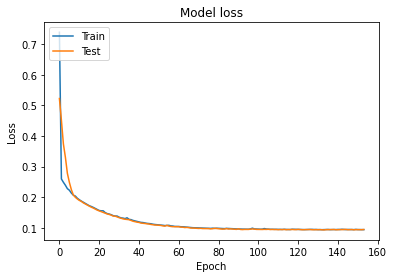

验证集上的最优结果是0.09654475003480911,对应训练轮次是4


[0.17751532793045044,
 0.18390193581581116,
 0.15807382762432098,
 0.15606428682804108,
 0.16155388951301575,
 0.13064393401145935,
 0.1431455761194229,
 0.12437869608402252,
 0.15302088856697083,
 0.09654475003480911]

In [11]:
results = []
# 调hidden_layer_dropout
for dropout_rate in dropout_rate_list:
    results.append(train_DNN(X_train,y_train,X_test,y_test,use_kernel_regularizer = True,kernel_regularizer = tf.keras.regularizers.l1(0.00001),hidden_layer_dropout=True, dropout_rate=dropout_rate))
    results.append(train_DNN(X_train,y_train,X_test,y_test,hidden_layer_num = 4,use_kernel_regularizer = True,kernel_regularizer = tf.keras.regularizers.l1(0.00001),hidden_layer_dropout=True, dropout_rate=dropout_rate))
results

create model. feature_dim =2300, label_dim =300
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_274 (Dense)           (None, 256)               589056    
                                                                 
 dense_275 (Dense)           (None, 256)               65792     
                                                                 
 dense_276 (Dense)           (None, 300)               77100     
                                                                 
Total params: 731,948
Trainable params: 731,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 5s 11ms/step - loss: 0.1738 - JI: 0.0227 - val_loss: 0.1065 - val_JI: 0.0274
Epoch 2/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0974 - JI: 0.0761 - val_loss: 0.0917 - val_JI: 0.0961


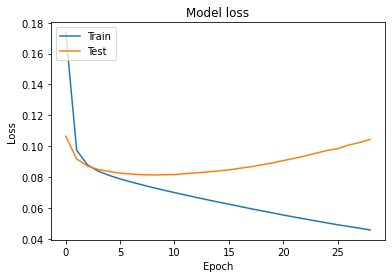

验证集上的最优结果是0.17900483310222626,对应训练轮次是14


0.17900483310222626

In [13]:
# 预测第二天用药，不用特征
x = df.iloc[:,5+72:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+300]
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

train_DNN(X_train,y_train,X_test,y_test)

create model. feature_dim =2372, label_dim =300
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_277 (Dense)           (None, 256)               607488    
                                                                 
 dense_278 (Dense)           (None, 256)               65792     
                                                                 
 dense_279 (Dense)           (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
110/110 [==============================] - 1s 10ms/step - loss: 0.4481 - JI: 0.0332 - val_loss: 0.1122 - val_JI: 0.0233
Epoch 2/500
110/110 [==============================] - 1s 8ms/step - loss: 0.1236 - JI: 0.0344 - val_loss: 0.1107 - val_JI: 0.0326


110/110 [==============================] - 1s 8ms/step - loss: 0.0759 - JI: 0.2036 - val_loss: 0.0808 - val_JI: 0.1771
Epoch 57/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0758 - JI: 0.2050 - val_loss: 0.0804 - val_JI: 0.1737
Epoch 58/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0761 - JI: 0.2036 - val_loss: 0.0821 - val_JI: 0.1871
Epoch 59/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0778 - JI: 0.1956 - val_loss: 0.0809 - val_JI: 0.1878
Epoch 60/500
110/110 [==============================] - 1s 9ms/step - loss: 0.0803 - JI: 0.1835 - val_loss: 0.0807 - val_JI: 0.1674
Epoch 61/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0790 - JI: 0.1953 - val_loss: 0.0798 - val_JI: 0.1790
Epoch 62/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0878 - JI: 0.1975 - val_loss: 0.0800 - val_JI: 0.1788
Epoch 63/500
110/110 [==============================] - 1s 8ms/step - loss: 0.0768 - JI: 

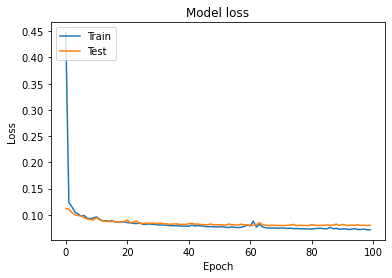

验证集上的最优结果是0.20646382868289948,对应训练轮次是96


0.20646382868289948

In [17]:
callbacks_list = [
    # This callback will interrupt training when we have stopped improving
     keras.callbacks.EarlyStopping(
    # This callback will monitor the validation accuracy of the model
    monitor='val_loss',
     # Training will be interrupted when the accuracy
     # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
     patience=20,
    ),
#     keras.callbacks.ReduceLROnPlateau(
#      # This callback will monitor the validation loss of the model
#      monitor='val_loss',
#      # It will divide the learning by 10 when it gets triggered
#      factor=0.1,
#      # It will get triggered after the validation loss has stopped improving
#      # for at least 10 epochs
#      patience=10,
#     ),
    # This callback will save the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
     filepath=r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\jupyter\model\my_model.h5', # Path to the destination model file
     # The two arguments below mean that we will not overwrite the
    # model file unless `val_loss` has improved, which
    # allows us to keep the best model every seen during training.
    monitor='val_loss',
    save_best_only=True,
    )
]


train_DNN(X_train,y_train,X_test,y_test,callbacks_list=callbacks_list)


In [26]:
# 统计预测用药长度与实际用药长度
from keras.models import load_model
model = load_model(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\jupyter\model\my_model.h5',compile = False)
pred = model.predict(X_test)
for i in range(len(pred)):
    count = 0
    intersaction_count = 0
    current_pred = pred[i]
    for j in range(len(current_pred)):
        if current_pred[j] > 0.3:
            count += 1
            if y_test[i][j] == 1:
                intersaction_count+=1
    print(count, list(y_test[i]).count(1),intersaction_count)
            

5 10 2
0 7 0
6 8 3
4 5 2
0 4 0
2 5 1
5 6 1
5 10 4
6 8 5
9 11 5
11 3 1
2 5 0
0 9 0
12 16 10
9 3 1
8 11 8
3 2 0
3 9 2
0 8 0
5 7 1
3 5 1
3 4 2
4 8 2
15 12 8
8 9 3
6 13 5
10 19 9
1 3 1
0 5 0
1 2 1
2 5 0
15 8 1
9 19 6
3 6 0
2 13 1
0 8 0
6 12 3
4 34 3
1 12 0
3 9 0
5 9 3
0 8 0
12 11 6
3 11 3
13 19 12
7 21 4
6 10 5
0 2 0
3 7 0
7 10 3
8 20 6
18 5 2
2 6 1
1 4 0
2 15 1
4 6 2
2 6 1
4 8 0
4 2 0
1 4 0
20 28 18
18 16 8
4 7 1
4 14 1
6 16 5
0 2 0
0 4 0
2 5 0
1 7 0
0 2 0
3 9 1
11 14 8
3 8 2
7 4 2
9 14 3
6 5 0
2 2 0
0 20 0
2 6 0
3 10 0
0 1 0
2 12 0
17 25 14
0 5 0
7 11 3
1 3 0
2 9 2
5 9 2
12 11 3
5 9 2
2 2 1
4 11 3
6 11 4
8 8 0
6 7 1
12 17 7
1 2 0
4 14 1
0 3 0
1 2 1
2 2 0
7 14 4
18 19 6
9 13 5
0 6 0
8 5 3
8 13 3
0 8 0
7 3 1
0 4 0
8 17 4
3 5 0
3 5 1
4 4 0
4 7 4
1 5 0
5 7 3
5 16 2
6 12 6
2 11 2
6 17 6
0 7 0
0 4 0
1 4 0
1 3 0
1 9 0
4 7 1
3 17 2
8 9 2
1 5 0
1 3 0
0 5 0
4 10 0
2 3 0
0 12 0
0 4 0
2 16 1
1 2 0
15 8 3
3 3 0
1 6 0
17 10 8
12 5 2
2 8 1
1 5 1
3 10 1
4 4 1
4 21 4
3 2 1
2 11 0
0 6 0
1 3 1
6 9 2
2 4 1


0 3 0
5 3 1
4 7 2
3 7 1
2 18 1
13 12 7
9 13 8
0 2 0
4 11 0
1 4 0
6 5 2
0 2 0
4 11 2
3 12 0
9 10 3
2 10 2
6 13 6
13 18 7
3 3 2
8 12 8
5 2 0
1 4 0
6 7 1
19 17 11
0 1 0
18 18 15
0 3 0
0 4 0
1 4 1
3 3 0
4 11 3
11 15 2
10 13 6
5 14 3
0 3 0
4 8 2
3 6 1
2 10 1
0 5 0
0 8 0
7 2 0
1 10 0
5 2 1
3 2 1
16 11 9
10 8 5
2 2 1
2 7 1
12 14 2
0 10 0
2 4 0
5 6 1
3 4 2
6 8 2
2 6 0
4 15 4
5 8 2
0 7 0
2 4 0
6 2 1
0 2 0
2 3 0
2 3 0
4 13 4
2 9 2
11 8 4
6 10 4
0 7 0
8 7 3
5 6 1
9 4 2
2 9 0
3 5 0
7 10 1
1 6 0
3 8 3
6 6 2
1 3 1
10 16 9
1 13 0
2 7 0
4 6 2
3 4 1
1 3 0
14 18 9
7 11 6
3 8 2
4 12 4
4 6 1
4 15 4
1 8 0
1 7 0
8 11 2
0 17 0
1 3 0
11 7 4
2 6 1
6 2 2
0 2 0
3 12 3
5 8 1
3 10 2
3 11 0
1 4 0
10 15 5
4 2 0
0 14 0
4 3 1
15 16 12
8 8 3
0 7 0
1 15 0
21 21 17
0 6 0
2 7 2
4 3 1
3 8 1
1 6 0
0 9 0
8 11 6
1 4 0
9 10 6
0 24 0
1 2 0
0 4 0
3 6 1
6 11 1
3 9 1
5 4 3
1 8 0
6 13 2
9 21 9
1 6 0
2 2 0
3 8 0
3 12 2
3 16 2
0 4 0
3 5 2
6 6 2
0 5 0
5 7 2
4 13 2
7 19 4
12 11 3
3 11 0
0 6 0
3 9 0
3 4 1
3 18 2
2 8 1
9 6 2
1 2 1
0 2 0


5 5 2
1 5 0
1 5 0
4 22 4
13 16 6
2 3 0
4 3 0
2 2 0
8 4 2
3 5 1
12 9 4
14 13 7
18 20 10
4 3 2
1 6 1
5 17 3
7 15 6
6 7 2
3 11 3
8 8 5
9 6 2
0 12 0
5 7 2
0 4 0
4 4 1
2 5 2
1 4 0
4 9 4
6 3 1
3 6 2
0 3 0
2 5 1
14 17 11
4 6 1
4 13 0
2 1 1
3 5 0
2 5 1
8 5 3
1 4 0
7 12 2
0 8 0
1 3 1
5 12 5
0 3 0
2 2 0
1 6 0
0 5 0
3 14 2
2 11 1
4 7 1
2 12 1
0 3 0
1 2 0
5 2 1
3 5 1
0 5 0
4 10 3
5 11 2
4 12 3
6 16 6
3 4 1
0 6 0
0 3 0
23 15 15
0 3 0
2 6 0
0 8 0
7 7 1
0 12 0
5 11 4
4 3 1
1 8 1
3 2 1
9 16 7
8 5 3
1 2 0
10 18 5
11 11 3
19 20 14
5 1 1
0 4 0
